# Generating Figures

This notebook will generate the figures from the anonymized ICML submission of the paper "Numerically Recovering the Critical Points of a Deep Linear Autoencoder" from the raw critfinder trajectory data.

There are a few steps that take an appreciable amount of time:

- Downloading the data (2.9 GB, variable time)
- Computing the Hessians and indices of critical points for Figures 1, 3, and 4 (20 min)
- Re-computing Hessians and indices for changing cutoffs in Figure 2 (10 min)
- Timing 100 iterations of each algorithm (15 min)



These values are underestimates for executing this notebook via Binder by approximately a factor of 3.

In [ ]:
import os
import sys

path_above = os.path.abspath("..")

%env PYTHONPATH={path_above}

sys.path.append(path_above)

In [2]:
import autograd.numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

import critfinder
import critfinder.utils

import figures
import utils

In [2]:
pd.options.mode.chained_assignment = None

warnings.filterwarnings(
    "ignore", category=FutureWarning,
    message="Using a non-tuple sequence for multidimensional indexing is deprecated;",
    module="autograd")

In [3]:
def clean_path_columns(df, path_columns, split_str, new_prefix):
    for path_column in path_columns:
        df[path_column] = df[path_column].apply(clean_path, args=(split_str, new_prefix))
        
def clean_path(path, split_str, new_prefix):
    path_end = path.split(split_str)[-1]
    return os.path.join(new_prefix, path_end)

def add_index_sets(cp_df):
    maps = cp_df.final_theta.apply(
        lambda theta: utils.theta_to_map(theta, NETWORK))
    index_sets = [utils.map_to_index_set(_map) for _map in maps]

    cp_df["index_set"] = index_sets

## Setup

### Downloading Data

The data for the paper is available as a zip at the Dropbox link below.

In [4]:
target_optimization_ID = "Borirv"

optimizations_dir = os.path.join("..", "results", "optimizations")

target_optimization_dir = os.path.join(optimizations_dir, target_optimization_ID)

In [5]:
download_link = "https://www.dropbox.com/s/dh2ilgnhrv2dxbf/Borirv.zip?dl=1"

if not os.path.exists(target_optimization_dir):
    !wget --max-redirect=20 -O Borirv.zip {download_link}
    !unzip Borirv.zip -d {optimizations_dir}
    !rm Borirv.zip

### Optimization

We create a dataframe of optimizations (combinations of data, network, and optimizer).
For the paper, we used only one optimization, so this dataframe as only one row.
We pull this row out by its ID and then reconstruct the data and network.

In [10]:
optimization_df = critfinder.utils.dataframes.construct_experiments_df(
    optimizations_dir)

target_optimization_row = optimization_df.loc[target_optimization_ID]

data, NETWORK, _ = critfinder.utils.load.from_paths(
    target_optimization_row.data_json,
    target_optimization_row.network_json,
    target_optimization_row.optimizer_json)

### Critfinders

The trajectories from that optimization (and the network and data) are used to construct critical point finding algorithms, or `critfinders`.

These are stored in a dataframe as well, `cf_df`.

In [8]:
critfinders_dir = os.path.join(
    os.path.dirname(target_optimization_row.data_json),
    "critfinders")

cf_df = critfinder.utils.dataframes.construct_experiments_df(
    critfinders_dir)

### Addt'l metadata

The metadata about hyperparameters, etc., for all of the critfinders is stored inside `finder_kwargs`, so we unpack that into new columns.

In [9]:
expanded_cf_df = pd.DataFrame.from_dict(
    dict(cf_df.finder_kwargs)
    ).transpose().join(cf_df)

In [11]:
expanded_cf_df.columns

Index(['alpha', 'beta', 'criterion_params', 'criterion_str', 'gammas',
       'log_kwargs', 'maxit', 'minimizer_params', 'minimizer_str', 'rho',
       'rtol', 'step_size', 'ID', 'experiment_json', 'finder_json',
       'finder_kwargs', 'finder_str', 'init_theta', 'optimization_path',
       'theta_perturb', 'trajectory_path'],
      dtype='object')

### Analytical Critical Points

The analytical critical points are pre-computed and stored in a pickled dataframe.

See `scripts/make_analytical_cps.py` for details on how these are computed.

In [12]:
data_folder = os.path.dirname(target_optimization_row.data_path)

pickle_path = os.path.join(data_folder, "analytical_cp_df.pkl")

In [13]:
analytical_cp_df = pd.read_pickle(os.path.join(data_folder, "analytical_cp_df.pkl"))

analytical_cp_df["morse_index"] = analytical_cp_df.hessian_spectrum.apply(
    utils.compute_morse_index)

### Critical Points for Figures

To create the figures, we need to select specific critfinders from the dataframe of critfinders, based on their metadata.
The function below implements this selection.
It then uses the IDs to create dataframes of possible critical points, `cp_df`s, for all selected critfinders.

In [15]:
def select_critfinders(cf_df, method_str, theta_perturbs=None, init_theta="uniform_f", 
                       min_runs=0, max_runs=1000):
    
    selector = cf_df.index.str.startswith(method_str) &\
               cf_df.init_theta.str.endswith(init_theta)
    
    if theta_perturbs is None:
        selector = selector & np.isnan(cf_df.theta_perturb)
    else:
        selector = selector & cf_df.theta_perturb.isin(theta_perturbs)
    
    cf_ids = expanded_cf_df.index[selector]
    
    cp_dfs =  utils.make_cp_dfs(cf_ids, cf_df)
    
    cp_dfs, cf_ids = zip(*[(cp_df, cf_id) for cp_df, cf_id in zip(cp_dfs, cf_ids)
                           if (len(cp_df) >= min_runs) & (len(cp_df) <= max_runs)])
    
    
    return cp_dfs, list(cf_ids)

#### Figures 1 & 2

In the first two figures, we are interested in all of the critfinders using a given algorithm that had exactly 15 runs and were initialized with no noise (`theta_perturbs=None`) and uniformly by height (`uniform_f`).

In [16]:
MR_cp_dfs, MR_cf_ids = select_critfinders(expanded_cf_df,
                                          method_str="newtonMR",
                                          min_runs=15, max_runs=15)
TR_cp_dfs, TR_cf_ids = select_critfinders(expanded_cf_df,
                                          method_str="newtonTR",
                                          min_runs=15, max_runs=15)
gnm_cp_dfs, gnm_cf_ids = select_critfinders(expanded_cf_df,
                                            method_str="gnm",
                                            min_runs=15, max_runs=15)

To view the hyperparameter values for a given list of critfinders and verify their correctness, provide the ids as a list to the metadata DataFrame, `expanded_cf_df`, as below:

In [17]:
expanded_cf_df.loc[MR_cf_ids].head()

,alpha,beta,criterion_params,criterion_str,gammas,log_kwargs,maxit,minimizer_params,minimizer_str,rho,...,step_size,ID,experiment_json,finder_json,finder_kwargs,finder_str,init_theta,optimization_path,theta_perturb,trajectory_path
newtonMR_FADydi,0.1,0.5,NaN,NaN,NaN,"{'track_theta': True, 'track_g': True, 'track_...",25,NaN,NaN,0.0001,...,NaN,newtonMR_FADydi,../results/optimizations/Borirv/critfinders/ne...,../results/optimizations/Borirv/critfinders/ne...,"{'log_kwargs': {'track_theta': True, 'track_g'...",newtonMR,uniform_f,../results/optimizations/Borirv,NaN,../results/optimizations/Borirv/trajectories/0...
newtonMR_ZkNtUm,0.1,0.5,NaN,NaN,NaN,"{'track_theta': True, 'track_g': True, 'track_...",25,NaN,NaN,0.0001,...,NaN,newtonMR_ZkNtUm,../results/optimizations/Borirv/critfinders/ne...,../results/optimizations/Borirv/critfinders/ne...,"{'log_kwargs': {'track_theta': True, 'track_g'...",newtonMR,uniform_f,../results/optimizations/Borirv,NaN,../results/optimizations/Borirv/trajectories/0...
newtonMR_KaXuiD,0.1,0.5,NaN,NaN,NaN,"{'track_theta': True, 'track_g': True, 'track_...",25,NaN,NaN,0.0001,...,NaN,newtonMR_KaXuiD,../results/optimizations/Borirv/critfinders/ne...,../results/optimizations/Borirv/critfinders/ne...,"{'log_kwargs': {'track_theta': True, 'track_g'...",newtonMR,uniform_f,../results/optimizations/Borirv,NaN,../results/optimizations/Borirv/trajectories/0...
newtonMR_oaAlIx,0.1,0.5,NaN,NaN,NaN,"{'track_theta': True, 'track_g': True, 'track_...",25,NaN,NaN,0.0001,...,NaN,newtonMR_oaAlIx,../results/optimizations/Borirv/critfinders/ne...,../results/optimizations/Borirv/critfinders/ne...,"{'log_kwargs': {'track_theta': True, 'track_g'...",newtonMR,uniform_f,../results/optimizations/Borirv,NaN,../results/optimizations/Borirv/trajectories/0...
newtonMR_IcYEaa,0.1,0.5,NaN,NaN,NaN,"{'track_theta': True, 'track_g': True, 'track_...",25,NaN,NaN,0.0001,...,NaN,newtonMR_IcYEaa,../results/optimizations/Borirv/critfinders/ne...,../results/optimizations/Borirv/critfinders/ne...,"{'log_kwargs': {'track_theta': True, 'track_g'...",newtonMR,uniform_f,../results/optimizations/Borirv,NaN,../results/optimizations/Borirv/trajectories/0...


For the performance comparison and cutoff figures, we want to combine across runs of a critfinder with the same parameters, but with different initializations, so we merge the cp_dfs above.

In [18]:
merged_MR_cp_df = pd.concat(MR_cp_dfs)

merged_TR_cp_df = pd.concat(TR_cp_dfs)

merged_gnm_cp_df = pd.concat(gnm_cp_dfs)

Some of these trajectories do not achieve sufficiently low squared gradient norm, and we want to be able to select these out with `utils.filter_to_candidate_cps`.
We also need to add the index information, using `utils.get_hessian_info`.
These two functions are combined in `to_candidate_cp` below.

For Figure 1, we're interested also in trajectories that failed, so we can optionally return those failed runs with the `return_failures` flag.

In [19]:
def to_candidate_cp(cp_df, network, return_failures=False):
    
    if return_failures:
        candidate_cp_df, failures_df = utils.filter_to_candidate_cps(
            cp_df, network, return_failures=True)
        candidate_cp_df["morse_index"] = utils.get_hessian_info(
            candidate_cp_df.final_theta, network)[-1]
        return candidate_cp_df, failures_df
    else:
        candidate_cp_df = utils.filter_to_candidate_cps(
            cp_df, network, return_failures=False)
        candidate_cp_df["morse_index"] = utils.get_hessian_info(
            candidate_cp_df.final_theta, network)[-1]
        
        return candidate_cp_df

In [20]:
merged_MR_candidate_cp_df, merged_MR_failures_df = to_candidate_cp(
    merged_MR_cp_df, NETWORK, return_failures=True)

In [21]:
merged_TR_candidate_cp_df, merged_TR_failures_df = to_candidate_cp(
    merged_TR_cp_df, NETWORK, return_failures=True)

In [22]:
merged_gnm_candidate_cp_df, merged_gnm_failures_df = to_candidate_cp(
    merged_gnm_cp_df, NETWORK, return_failures=True)

#### Figure 3 - Noise and Bias - Uniform Height

For the bottom row of Figure 3, we are interested in `newtonMR` runs with additive noise (`theta_perturb != None`).
These are selected below.

In [23]:
noisy_unif_height_cp_dfs, noisy_unif_height_cf_ids = select_critfinders(
    expanded_cf_df, method_str="newtonMR",
    theta_perturbs=[-4, -2, -1], init_theta="uniform_f")

These are returned unsorted, so we sort them by `theta_perturbs`.

In [24]:
def sort_dfs_by(key, dfs, cf_ids, cf_df):
    l = list(zip(
        dfs, cf_df.loc[cf_ids][key].values))
    sorted_dfs, sorted_key_vals = zip(*list(sorted(l, key=lambda tup: tup[1])))
    return list(sorted_dfs), list(sorted_key_vals)

In [25]:
noisy_unif_height_cp_dfs, noisy_unif_height_theta_perturbs = sort_dfs_by(
    "theta_perturb", noisy_unif_height_cp_dfs, noisy_unif_height_cf_ids, expanded_cf_df)

In [26]:
noisy_unif_height_candidate_cp_dfs = [to_candidate_cp(cp_df, NETWORK)
                                      for cp_df in noisy_unif_height_cp_dfs]

For the top-left panel, demonstrating bias, we need critfinders with more runs (50) but without noise.

In [27]:
unif_height_bias_cp_dfs, unif_height_bias_cf_ids = select_critfinders(
    expanded_cf_df, method_str="newtonMR", theta_perturbs=None,
    max_runs=50, min_runs=50)

In [28]:
unif_height_bias_candidate_cp_dfs = [to_candidate_cp(cp_df, NETWORK)
                                     for cp_df in unif_height_bias_cp_dfs]

In the bottom row, we also compare to a run without noise, in order to show that low noise values don't change the set of critical points that is recovered.

In [29]:
unif_height_noiseless_cp_dfs, unif_height_noiseless_cf_ids = select_critfinders(
    expanded_cf_df, method_str="newtonMR", theta_perturbs=None,
    max_runs=100, min_runs=100)

In [30]:
unif_height_noiseless_candidate_cp_dfs = [to_candidate_cp(cp_df, NETWORK)
                                          for cp_df in unif_height_noiseless_cp_dfs]

#### Figure 4 - Noise and Bias - Uniform Iteration

Figure 4 is the same as Figure 3, but with `init_theta == uniform`, referred to in the paper as "Uniform Iteration", rather than `uniform_f`.

In [30]:
noisy_unif_iteration_cp_dfs, noisy_unif_iteration_cf_ids = select_critfinders(
    expanded_cf_df, method_str="newtonMR",
    theta_perturbs=[-4, -2, -1], init_theta="uniform")

In [33]:
noisy_unif_iteration_cp_dfs, noisy_unif_iteration_theta_perturbs = sort_dfs_by(
    "theta_perturb", noisy_unif_iteration_cp_dfs,
    noisy_unif_iteration_cf_ids, expanded_cf_df)

In [34]:
noisy_unif_iteration_candidate_cp_dfs = [to_candidate_cp(cp_df, NETWORK)
                                         for cp_df in noisy_unif_iteration_cp_dfs]

In [35]:
unif_iteration_bias_cp_dfs, unif_iteration_bias_cf_ids = select_critfinders(
    expanded_cf_df, method_str="newtonMR", theta_perturbs=None, init_theta="uniform",
    max_runs=50, min_runs=50)

In [37]:
unif_iteration_bias_candidate_cp_dfs = [to_candidate_cp(cp_df, NETWORK)
                                        for cp_df in unif_iteration_bias_cp_dfs]

In [38]:
unif_iteration_noiseless_cp_dfs, unif_iteration_noiseless_cf_ids = select_critfinders(
    expanded_cf_df, method_str="newtonMR", theta_perturbs=None, init_theta="uniform",
    max_runs=100, min_runs=50)

In [39]:
unif_iteration_noiseless_candidate_cp_dfs = [to_candidate_cp(cp_df, NETWORK)
                                             for cp_df in unif_iteration_noiseless_cp_dfs]

# Figure 1 - Performance Comparison

In [33]:
candidate_cp_dfs = [merged_MR_candidate_cp_df,
                merged_TR_candidate_cp_df,
                merged_gnm_candidate_cp_df,
                    ]

failed_cp_dfs = [merged_MR_failures_df, merged_TR_failures_df, merged_gnm_failures_df]

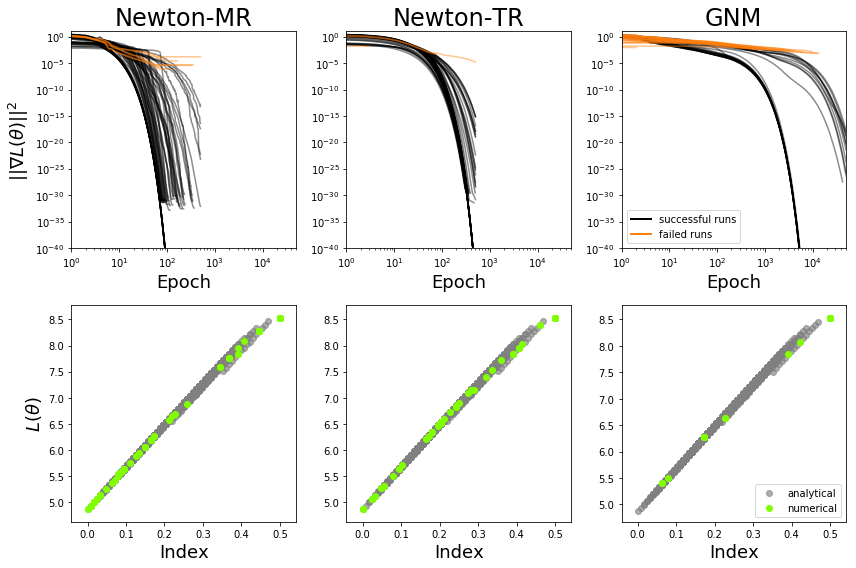

In [34]:
titles = ["Newton-MR", "Newton-TR", "GNM"]
f, axs = figures.make_performance_comparison_figure(
    candidate_cp_dfs, analytical_cp_df, titles=titles,
    failed_cp_dfs=failed_cp_dfs, base_figure_scale=4);

plt.tight_layout();

In [87]:
f.savefig("fig-algorithm-performance.svg")

### Performance

#### Iteration Counts

In [35]:
def add_iter_count(cp_df):
    cp_df["num_iters"] = cp_df.thetas.apply(lambda thetas: len(thetas)-1)
    return cp_df

In [36]:
merged_MR_candidate_cp_df = add_iter_count(merged_MR_candidate_cp_df)

In [37]:
merged_TR_candidate_cp_df = add_iter_count(merged_TR_candidate_cp_df)

In [38]:
merged_MR_candidate_cp_df.num_iters.describe()

count     69.000000
mean     260.623188
std      177.088554
min       76.000000
25%       98.000000
50%      185.000000
75%      500.000000
max      500.000000
Name: num_iters, dtype: float64

In [39]:
merged_TR_candidate_cp_df.num_iters.describe()

count     69.000000
mean     436.318841
std       79.746380
min      311.000000
25%      344.000000
50%      500.000000
75%      500.000000
max      500.000000
Name: num_iters, dtype: float64

The distribution of iterations is strongly non-Gaussian, so we use the Mann-Whitney $U$ test.

In [40]:
scipy.stats.mannwhitneyu(merged_MR_candidate_cp_df.num_iters,
                         merged_TR_candidate_cp_df.num_iters)

MannwhitneyuResult(statistic=1123.0, pvalue=1.0716768138927361e-08)

#### Failed Runs

Gradient norm minimization fails at a much higher rate than the other algorithms.

In [41]:
len(merged_gnm_failures_df)/len(merged_gnm_cp_df)

0.6266666666666667

#### Wall Times

Note that results here won't precisely match those in the paper, since the compute resources will likely be different.
It should still be the case that GNM is faster per iteration than Newton-MR, which is faster than Newton-TR.
It should also still be the case that GNM is less than 100 times faster per iteration than Newton-MR (for us, approximately only 4 times faster).

In [51]:
init_theta = merged_MR_candidate_cp_df.iloc[0].thetas[0]

example_MR_run = expanded_cf_df.loc[MR_cf_ids].iloc[0]
MR_kwargs = example_MR_run.finder_kwargs

MR_kwargs["log_kwargs"] = {}

In [52]:
newtonMR_experiment = critfinder.FastNewtonMR(NETWORK.loss, **MR_kwargs)

In [53]:
%%timeit
theta = newtonMR_experiment.run(init_theta, iters=100)

21.4 s ± 908 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
init_theta = merged_TR_candidate_cp_df.iloc[0].thetas[0]

example_TR_run = expanded_cf_df.loc[TR_cf_ids].iloc[0]

TR_kwargs = example_TR_run.finder_kwargs

TR_kwargs["log_kwargs"] = {}

In [55]:
newtonTR_experiment = critfinder.finders.newtons.FastNewtonTR(NETWORK.loss, **TR_kwargs)

In [56]:
%%timeit
theta = newtonTR_experiment.run(init_theta, iters=100)

1min 27s ± 2.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
init_theta = merged_gnm_candidate_cp_df.iloc[0].thetas[0]

gnm_kwargs = expanded_cf_df.loc[gnm_cf_ids].iloc[0].finder_kwargs

gnm_kwargs["log_kwargs"] = {}

In [58]:
gnm_experiment = critfinder.finders.gradnormmin.GradientNormMinimizer(NETWORK.loss,
                                                                      **gnm_kwargs)

In [59]:
%%timeit
theta = gnm_experiment.run(init_theta, num_iters=100)

5.88 s ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Figure 2 - Cutoffs Comparison

We compare cutoffs by pretending that we stopped iteration as soon as the squared gradient norm reached the cutoff value.

`compute_cutoff_cp_dfs` below implements this on a raw `cp_df` (one that has not been filtered to candidate cps!) by calling `filter_to_candidate_cps` with the `cut_early` flag.

In [60]:
def compute_cutoff_cp_dfs(base_cp_df, cutoffs, network=NETWORK):
    
    cutoff_cp_dfs = []
    cutoff_morse_index_lists = []
    
    for cutoff in cutoffs:
        
        cutoff_cp_df = utils.filter_to_candidate_cps(base_cp_df,
                                                     network, cutoff,
                                                     cut_early=True)
        
        _, _, morse_indices = utils.get_hessian_info(cutoff_cp_df.candidate_theta,
                                               network)
        cutoff_cp_df["morse_index"] = morse_indices
        cutoff_cp_dfs.append(cutoff_cp_df)
        
    return cutoff_cp_dfs

Note that the cell below takes a few minutes to run on typical hardware.

In [61]:
cutoffs = [1e-10, 1e-8, 1e-6, np.inf]

cutoff_cp_dfs = compute_cutoff_cp_dfs(merged_MR_cp_df, cutoffs)

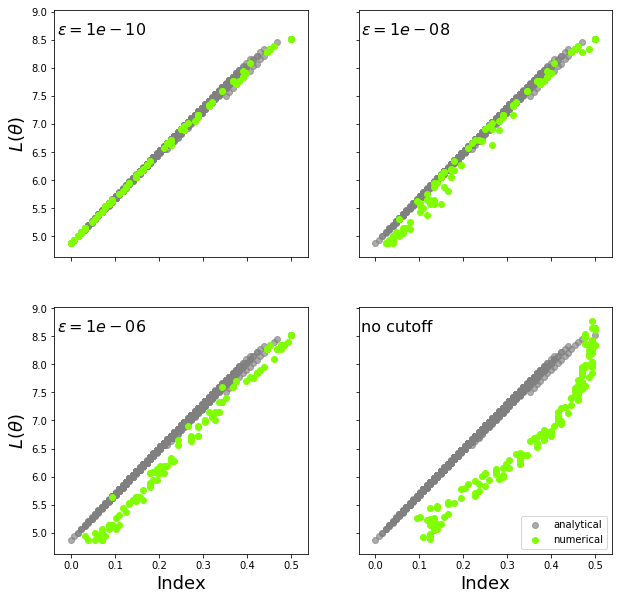

In [88]:
f, axs = figures.make_cutoff_comparison_figure(
    cutoff_cp_dfs, cutoffs, analytical_cp_df, base_figure_scale=5);

In [91]:
f.savefig("fig-cutoffs.svg")

# Figure 3 - Sampling Bias and Noise - Uniform Height

Figures 3 and 4 are the same visualization applied to different data.
In Figure 3, we apply it to critfinders whose initial points were sampled uniformly with respect to loss value ("Uniform Height", in the paper).

In the top left, we have the distribution of eigenvector IDs onto which recovered critical points performed projection.
These come from the `bias_cp_dfs`, since they show the bias towards low eigenvector IDs.

The effect of varying levels of additive noise on this bias is examined in this figure.
The results come from the `noisy_unif_{height,iter}_candidate_cp_dfs`.

The entropy of the eigenvector distributions is computed and compared in the top right panel.
This will be applied to all `cp_df`s provided as the `entropy_cp_dfs` argument to `make_bias_noise_figure`.

The `noisy` critical points are compared to the analytical critical points from `analytical_cp_df` and to the critical points found by their noiseless version, provided as the `noiseless_cp_df` argument.

In [42]:
unif_height_bias_cp_df_labels = ["Trajectory " + str(ii+1)
                                 for ii in range(len(unif_height_bias_cp_dfs))]
[add_index_sets(cp_df) for cp_df in unif_height_bias_candidate_cp_dfs]

unif_height_noise_levels = [10 ** theta_perturb
                            for theta_perturb in noisy_unif_height_theta_perturbs]
[add_index_sets(cp_df) for cp_df in noisy_unif_height_candidate_cp_dfs]

unif_height_entropy_cp_dfs = [unif_height_noiseless_candidate_cp_dfs[0]]\
                             + list(noisy_unif_height_candidate_cp_dfs)
[add_index_sets(cp_df) for cp_df in unif_height_entropy_cp_dfs]

unif_height_entropy_cp_df_labels = ["Uniform\nHeight"] +\
                                   [r"""$\sigma={0}$""".format(noise_level)
                                    for noise_level in unif_height_noise_levels]

/home/charles/venvs/autograd/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log2
  return f_raw(*args, **kwargs)


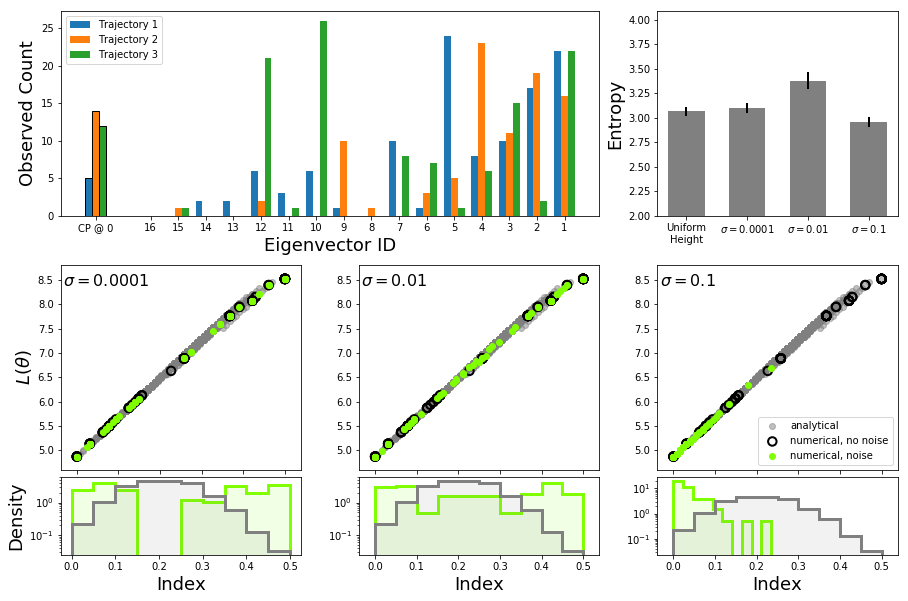

In [44]:
f, _, _, _ = figures.make_bias_noise_figure(
                       unif_height_bias_candidate_cp_dfs,
                       unif_height_entropy_cp_dfs,
                       noisy_unif_height_candidate_cp_dfs,
                       unif_height_noise_levels,
                       unif_height_noiseless_candidate_cp_dfs[0],
                       analytical_cp_df,
                       bias_cp_df_labels=unif_height_bias_cp_df_labels,
                       entropy_cp_df_labels=unif_height_entropy_cp_df_labels,
                       base_figure_scale=5);

for ax in f.axes:
    if not ax.has_data():
        ax.axis("off")

In [93]:
f.savefig("fig-bias-unif-height.svg")

The entropy is computed from the results of a run.
Since the runs are independent and identically distributed, we can bootstrap resample them to get a sense of the variability in the entropies and perform statistical testing.

In [45]:
def bootstrap_entropies(cp_df, num_bootstraps=100):
    return [utils.compute_entropy(cp_df.sample(len(cp_df), replace=True))
            for _ in range(num_bootstraps)]

In [46]:
entropies = [utils.compute_entropy(cp_df) for cp_df in unif_height_entropy_cp_dfs]

entropy_bootstraps = [bootstrap_entropies(cp_df)
                      for cp_df in unif_height_entropy_cp_dfs]

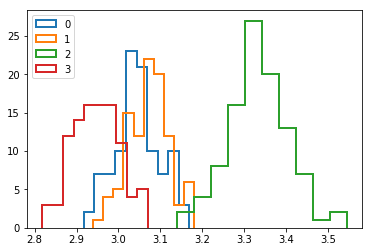

In [47]:
[plt.hist(entropy_bootstrap, label=ii, histtype="step", linewidth=2)
 for ii, entropy_bootstrap
 in enumerate(entropy_bootstraps)];
plt.legend();

In [48]:
print(np.mean(entropy_bootstraps[0]), np.mean(entropy_bootstraps[2]))

3.046014471864771 3.3330683484303933


In [49]:
scipy.stats.ttest_ind(entropy_bootstraps[0], entropy_bootstraps[2])

Ttest_indResult(statistic=-31.37683643668336, pvalue=9.010373229899694e-79)

# Figure 4 - Sampling Bias and Noise - Uniform Iteration

See Figure 3 description.

Figure 4 uses critfinders whose initial points are sampled randomly from the optimization trajectory.

In [73]:
unif_iteration_bias_cp_df_labels = ["Trajectory " + str(ii+1)
                                    for ii in range(len(unif_iteration_bias_cp_dfs))]
[add_index_sets(bias_cp_df) for bias_cp_df in unif_iteration_bias_candidate_cp_dfs]

unif_iteration_noise_levels = [10 ** theta_perturb
                            for theta_perturb in noisy_unif_iteration_theta_perturbs]
[add_index_sets(cp_df) for cp_df in noisy_unif_iteration_candidate_cp_dfs]

unif_iteration_entropy_cp_dfs = [unif_height_noiseless_candidate_cp_dfs[0],
                                 noisy_unif_height_candidate_cp_dfs[1],
                                 unif_iteration_noiseless_candidate_cp_dfs[0],
                                 noisy_unif_iteration_candidate_cp_dfs[1]]

[add_index_sets(entropy_cp_df) for entropy_cp_df in unif_iteration_entropy_cp_dfs]
unif_iteration_entropy_cp_df_labels = ["Uniform\nHeight",
                                       r"""Unif Height,
 $\sigma=${0}""".format(1e-2),
                                       "Uniform\nIteration",
                                       r"""Unif Iteration,
 $\sigma=${0}""".format(1e-2)]

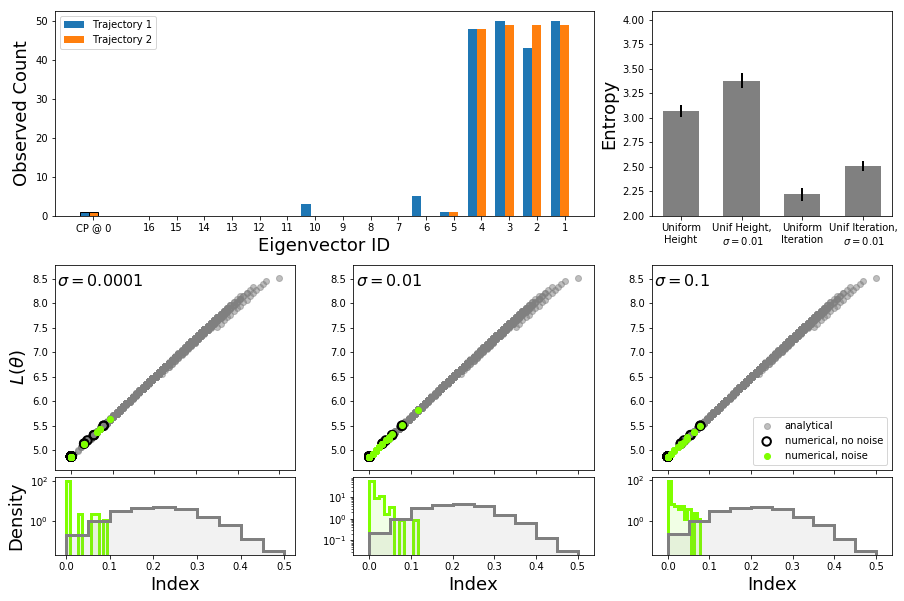

In [94]:
f, _, _, _ = figures.make_bias_noise_figure(
                       unif_iteration_bias_candidate_cp_dfs,
                       unif_iteration_entropy_cp_dfs,
                       noisy_unif_iteration_candidate_cp_dfs,
                       unif_iteration_noise_levels,
                       unif_iteration_noiseless_candidate_cp_dfs[0],
                       analytical_cp_df,
                       bias_cp_df_labels=unif_iteration_bias_cp_df_labels,
                       entropy_cp_df_labels=unif_iteration_entropy_cp_df_labels,
                       base_figure_scale=5);

for ax in f.axes:
    if not ax.has_data():
        ax.axis("off")

In [95]:
f.savefig("fig-bias-unif-iteration.svg")

In [79]:
entropies = [utils.compute_entropy(cp_df) for cp_df in unif_iteration_entropy_cp_dfs]

entropy_bootstraps = [bootstrap_entropies(cp_df)
                      for cp_df in unif_iteration_entropy_cp_dfs]

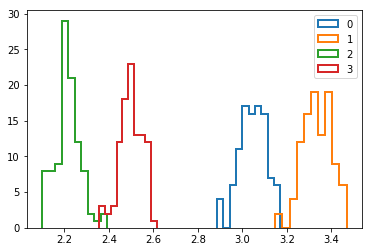

In [80]:
[plt.hist(entropy_bootstrap, label=ii, histtype="step", linewidth=2)
 for ii, entropy_bootstrap
 in enumerate(entropy_bootstraps)];
plt.legend();

In [81]:
print(np.mean(entropy_bootstraps[0]), np.mean(entropy_bootstraps[2]))

3.0487229435779777 2.2175211290734698


In [82]:
scipy.stats.ttest_ind(entropy_bootstraps[0], entropy_bootstraps[2])

Ttest_indResult(statistic=100.71837638699624, pvalue=4.790974634729432e-172)

In [83]:
print(np.mean(entropy_bootstraps[0]), np.mean(entropy_bootstraps[3]))

3.0487229435779777 2.50198724467298


In [84]:
scipy.stats.ttest_ind(entropy_bootstraps[0], entropy_bootstraps[3])

Ttest_indResult(statistic=68.87870059611, pvalue=2.7097777411406093e-140)